# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
# Part I - Probability

To get started, let's import our libraries.

In [38]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [39]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [40]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [41]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

The proportion of users converted.

In [42]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

(group,landing_page) = (treatment, new_page). 

There are two possibility where new_page and treatment don't line up : 

first : (group,landing_page) = (treatment,old_page)

second : (group,landing_page) = (control,new_page)

In [43]:
first_df = len(df.query('group == "treatment" and landing_page == "old_page"'))

In [44]:
second_df = len(df.query('group == "control" and landing_page == "new_page"'))

In [45]:
e = first_df + second_df 
e

3893

Do any of the rows have missing values?

In [46]:
missing = df.isnull().sum()
missing

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No, there is no missing value.

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In other words, I will be sure data only includes:
(group,landing_page) = (treatment, new_page) and
(group,landing_page) = (control, old_page) as dropping the others.

In [47]:
#df2 = df.drop(df.query('group == "treatment" and landing_page != "new_page" | group == "control" and landing_page != "old_page"').index)

# Second method
df2 = df[((df['group'] == "treatment") & (df['landing_page'] == "new_page")) | ((df['group'] == "control") & (df['landing_page'] == "old_page"))]


<span style="color: purple;">Double Check all of the correct rows were removed - this should be 0</span>.

In [48]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [49]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [50]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [51]:
duplicated_user = df2[df2['user_id'].duplicated()]
duplicated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [52]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [53]:
df2 = df2.drop([2893])

Now, checking if it is still duplicated or the code works:

In [54]:
df2[df2['user_id'].duplicated()].any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

a. What is the probability of an individual converting regardless of the page they receive?

In [55]:
p_pool = df2.converted.mean()
p_pool

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [56]:
p_control = df2.query('group == "control"').converted.mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [57]:
p_treatment = df2.query('group == "treatment"').converted.mean()
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [58]:
p_newpage = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
p_newpage 

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [59]:
obs_diff = p_treatment - p_control
print('Observed difference is: {}'.format(obs_diff))

Observed difference is: -0.0015782389853555567


* For now, it cannot be said that the new treatment page leads to more conversions, I haven't got any sufficient evidence to support the statement. 

* I found that p_control = 0.1203 = %12 and p_treatment = 0.1188 = %11. In other words, treatment groups' and control groups' converted rates are too close to each other to have an idea. There is only 0.001 difference between them as can be seen from obs_diff above. 

* The probability of received new page or old page comes out 50-50%.

* To decide the page treatment, I need to test null hypothesis and try to have more evidence.

In [60]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

In [61]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

In [94]:
z_score_5 = 1.96 # For a p value of 5 percent
pooled_SE = math.sqrt(p_pool * (1-p_pool) * (1.0/n_new + 1.0/n_old))
pooled_SE

0.0012039132295014454

In [63]:
d_hat = p_treatment - p_control
d_hat

-0.0015782389853555567

In [96]:
z_score_5 * pooled_SE

0.002359669929822833

In [95]:
print('The upper bound is {}'.format(d_hat + z_score_5 * pooled_SE))
print('The lower bound is {}'.format(d_hat - z_score_5 * pooled_SE))

The upper bound is 0.0007814309444672761
The lower bound is -0.00393790891517839


In [111]:
z_score = abs(d_hat) / math.sqrt(p_pool * (1-p_pool) * (1.0/n_new + 1.0/n_old))
z_score

1.3109241984234394

<span style="color: blue;"> If d_hat > abs(z_score_5 * pooled_SE) then we could have rejected the null hypothesis. However, that iss not the case
</span>.

* we can ue the following tool to get the p value which is 0.18988
* P value shows the statistical significance of the difference between the control and treatement group. As d_hat becomes larger, the p-value will decrease which shows that the null-hypothesis is wrong.
* Since our $p$-value=0.18988 is way above our $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that our new design did not perform significantly different (let alone better) than our old one :(

https://www.calculator.net/z-score-calculator.html

<a id='ab_test'></a>
# Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

One-sided T-test:

**H_0:  𝑝𝑜𝑙𝑑 ≥ 𝑝𝑛𝑒𝑤**

**H_1: 𝑝𝑜𝑙𝑑  < 𝑝𝑛𝑒𝑤**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>


**Assuming $p_{new}$ = $p_{old}$**

**Sample size=ab_data sample size**

a. What is the **convert rate** for $p_{new}$ under the null? 

In [66]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [67]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [68]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [69]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [70]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.12043217947835662

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [71]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.12080620069661467

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [72]:
difference = new_page_converted.mean() - old_page_converted.mean()
print('Simulated difference is: {}'.format(difference))

Simulated difference is: -0.0003740212182580527


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [73]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

* The function np.random.binomial creates a number between zero and n_new/n_old. Diving by n_new/n_old will create the probability value

In [74]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

* under null hypothesis p_con - p_treat should have a normal distribution around zero

(array([  18.,  192.,  803., 2054., 2921., 2405., 1214.,  335.,   54.,
           4.]),
 array([-0.00427639, -0.00336235, -0.00244831, -0.00153426, -0.00062022,
         0.00029382,  0.00120786,  0.00212191,  0.00303595,  0.00394999,
         0.00486404]),
 <BarContainer object of 10 artists>)

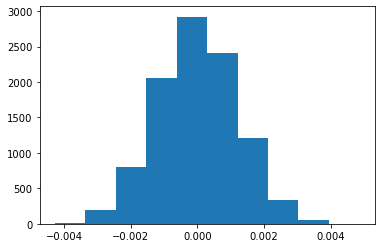

In [75]:
plt.hist(p_diffs) 

<span style="color: blue;">Looks pretty normal, it's a normal distribution.</span>


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

<span style="color: purple;">Creating distribution under the null hypothesis:</span>

In [76]:
p_diffs.std()

0.001208003965397526

In [77]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

<span style="color: blue;">red line shows the observed difference (obs_diff = p_treatment - p_control)
</span>.

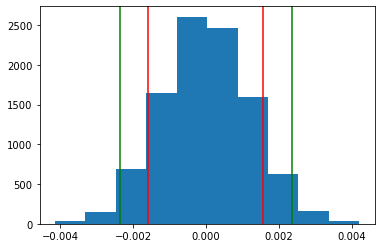

In [113]:
plt.hist(null_vals)
plt.axvline(x=obs_diff, c='red')
plt.axvline(x=-obs_diff, c='red')
plt.axvline(x=-z_score_5 * pooled_SE, c='green')
plt.axvline(x=z_score_5 * pooled_SE, c='green')

<span style="color: purple;">Computing the p-value:
</span>

* area under the curve outside red line which is larger than it should be

In [108]:
(null_vals < obs_diff).mean() + (null_vals > -obs_diff).mean() 

0.1931

* area under the curve outside green line

In [114]:
(null_vals < -z_score_5 * pooled_SE).mean() + (null_vals > z_score_5 * pooled_SE).mean()

0.0495

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<span style="color: blue;">
I computed as called in scientific studies "p-value" in part j.
This statistic came from the null distribution, p-value = 0.1931 > 0.05. So that, do not reject the 𝑝𝑛𝑒𝑤  =  𝑝𝑜𝑙𝑑, null hypothesis.
</span>


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [81]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [103]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = "two-sided")
z_score, p_value

print('Z-score: {}'.format(z_score))
print('P-value of Z-Test: {}'.format(p_value))

Z-score: 1.3109241984234394
P-value of Z-Test: 0.18988337448195103


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<span style="color: blue;">
Both z-score and p-value computations from the test statistic suggest that findings fail to reject the null hypothesis. 
Also as being both of p-values are equal to 0.189,when calculated as not computing 'the alternative'. They agree with the findings in part j. and k. 
    </span>